In [25]:
%pip install pandas
%pip install scikit-learn
%pip install numpy
%pip install gensim
%pip install scipy
%pip install xgboost
%pip install seaborn
%pip install pyspark
%pip install autogluon

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [24]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Cassandra Example") \
    .config("spark.cassandra.connection.host", "127.0.0.1") \
    .config("spark.cassandra.connection.port", "9042") \
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.4.0") \
    .getOrCreate()

In [1]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
import gensim.downloader as api
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
df = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="data", keyspace="space") \
    .load()
df.show(n=df.count())

+----+--------------------+--------------------+--------------------+------------+--------------------+
|Year|               Title|  AffiliationCountry|      AuthorKeywords|CitedByCount|     PublicationName|
+----+--------------------+--------------------+--------------------+------------+--------------------+
|1979|Benzo[a]pyrene me...|             Belgium|                NULL|          18|Chemico-Biologica...|
|1979|Binding of 6-hydr...|       United States|3-MC, 3-methylcho...|          15|Chemico-Biologica...|
|1979|Comparative Tumor...|Mexico, United St...|                NULL|          65|     Cancer Research|
|1979|New antibiotics f...|               Italy|                NULL|           7|The Journal of An...|
|1979|The formation of ...|      United Kingdom|                NULL|          24|Chemico-Biologica...|
|2022|"What is an ""eff...|  Australia,Thailand|ASEAN,Asian busin...|           1|Singapore Economi...|
|2022|'AMR Dialogues': ...|Thailand,United K...|Antibiotics,Anti

In [19]:
df = df.toPandas()

In [21]:
direct_df = pd.read_csv("../2_data_combined.csv")
direct_df

,Year,Title,PublicationName,CitedByCount,AffiliationCountry,AuthorKeywords
0,2021,Does proactive logistics management enhance bu...,Polish Journal of Management Studies,0,"Thailand,Thailand,Thailand,Myanmar,Thailand","Business management,Firm size,Logistics awaren..."
1,2021,"Will There Ever Be Cure for Chronic, Life-Chan...",Frontiers in Medicine,3,"Thailand,Thailand,Thailand,Thailand,Thailand,J...","biofilm infections,chronic infection,chronic u..."
2,2021,Bacterial diversity and potential risk factors...,PeerJ,6,"United States,Thailand","Escherichia coli,Risk factors,Salmonella enter..."
3,2021,Global Perspectives on Immunization Against SA...,Frontiers in Immunology,9,"Canada,South Africa,South Africa,United States...","COVID-19,maternal immunization,maternal vaccin..."
4,2021,Deep Learning Enables Prostate MRI Segmentatio...,Frontiers in Oncology,4,"United States,United States,China,Thailand,Uni...","deep attentive neural network,large cohort eva..."
...,...,...,...,...,...,...
9662,2021,A review on microbial products and their persp...,Biomolecules,37,"India, Italy, Sweden","Bacteriocins, Chlorellin, Filamentous fungi, H..."
9663,2000,"Highly diastereoselective synthesis of 2,3-dih...",Arkivoc,7,United Kingdom,NaN
9664,2010,Negative regulation of gamma-aminobutyric acid...,Neural Regeneration Research,1,China,"Calcium ion, Facial nerve injury, Facial nucle..."
9665,2022,A Transcriptomic Response to Lactiplantibacill...,International Journal of Molecular Sciences,3,Saudi Arabia,"fatty liver diseases, high-fat diet, L. planta..."


In [22]:
country_to_continent = {
    "Sweden": "Europe", "South Africa": "Africa", "Armenia": "Asia", "Netherlands": "Europe",
    "Maldives": "Asia", "Macao": "Asia", "Slovenia": "Europe", "Barbados": "North America",
    "Bangladesh": "Asia", "Mexico": "North America", "Taiwan": "Asia", "Georgia": "Asia",
    "Bhutan": "Asia", "South Sudan": "Africa", "Congo": "Africa", "Algeria": "Africa",
    "Belize": "North America", "Zimbabwe": "Africa", "Iran": "Asia", "Hungary": "Europe",
    "Latvia": "Europe", "Belgium": "Europe", "Denmark": "Europe", "Italy": "Europe",
    "Albania": "Europe", "Iceland": "Europe", "Democratic Republic Congo": "Africa",
    "Botswana": "Africa", "Monaco": "Europe", "Mauritius": "Africa", "Guatemala": "North America",
    "Madagascar": "Africa", "Somalia": "Africa", "Togo": "Africa", "Reunion": "Africa",
    "Bulgaria": "Europe", "El Salvador": "North America", "Sri Lanka": "Asia",
    "South Korea": "Asia", "Sudan": "Africa", "Kyrgyzstan": "Asia", "Brunei Darussalam": "Asia",
    "North Macedonia": "Europe", "Bahamas": "North America", "Qatar": "Asia", "Timor-Leste": "Asia",
    "United States": "North America", "Bahrain": "Asia", "Mali": "Africa", "Angola": "Africa",
    "Namibia": "Africa", "India": "Asia", "Venezuela": "South America", "Russian Federation": "Europe",
    "Viet Nam": "Asia", "Canada": "North America", "Cuba": "North America", "Ireland": "Europe",
    "Panama": "North America", "Oman": "Asia", "Senegal": "Africa", "Montenegro": "Europe",
    "Guinea-Bissau": "Africa", "Seychelles": "Africa", "Yemen": "Asia", "Peru": "South America",
    "Pakistan": "Asia", "Chad": "Africa", "Finland": "Europe", "Paraguay": "South America",
    "Yugoslavia": "Europe", "Azerbaijan": "Asia", "Tunisia": "Africa", "Kazakhstan": "Asia",
    "Moldova": "Europe", "Austria": "Europe", "Malaysia": "Asia", "Rwanda": "Africa",
    "Hong Kong": "Asia", "Cameroon": "Africa", "Papua New Guinea": "Oceania",
    "Czech Republic": "Europe", "Cambodia": "Asia", "Gabon": "Africa", "Niger": "Africa",
    "Portugal": "Europe", "Switzerland": "Europe", "New Zealand": "Oceania", "Singapore": "Asia",
    "Trinidad and Tobago": "North America", "Syrian Arab Republic": "Asia", "Jordan": "Asia",
    "France": "Europe", "Cote d'Ivoire": "Africa", "Eritrea": "Africa", "Argentina": "South America",
    "United Arab Emirates": "Asia", "Sierra Leone": "Africa", "Uruguay": "South America",
    "China": "Asia", "Burundi": "Africa", "Cape Verde": "Africa", "Myanmar": "Asia",
    "Egypt": "Africa", "Unknown": "Unknown", "Nicaragua": "North America", "Thailand": "Asia",
    "Liberia": "Africa", "Central African Republic": "Africa", "Puerto Rico": "North America",
    "Ecuador": "South America", "Spain": "Europe", "Brazil": "South America", "Gambia": "Africa",
    "Nepal": "Asia", "Kuwait": "Asia", "Afghanistan": "Asia", "Swaziland": "Africa",
    "Romania": "Europe", "French Guiana": "South America", "Germany": "Europe",
    "Bolivia": "South America", "Australia": "Oceania", "Greece": "Europe", "Uzbekistan": "Asia",
    "Israel": "Asia", "Chile": "South America", "Uganda": "Africa", "Haiti": "North America",
    "Morocco": "Africa", "Poland": "Europe", "Philippines": "Asia", "Mozambique": "Africa",
    "Guyana": "South America", "Zambia": "Africa", "Serbia": "Europe", "Jamaica": "North America",
    "Belarus": "Europe", "Cyprus": "Europe", "United Kingdom": "Europe", "Guinea": "Africa",
    "Honduras": "North America", "Laos": "Asia", "Indonesia": "Asia", "Fiji": "Oceania",
    "Costa Rica": "North America", "Mauritania": "Africa", "Aruba": "North America",
    "Colombia": "South America", "Burkina Faso": "Africa", "Slovakia": "Europe",
    "Dominican Republic": "North America", "Tanzania": "Africa", "Norway": "Europe",
    "Mongolia": "Asia", "Ukraine": "Europe", "Ghana": "Africa", "Iraq": "Asia",
    "Saudi Arabia": "Asia", "Benin": "Africa", "Luxembourg": "Europe",
    "Bosnia and Herzegovina": "Europe", "Lithuania": "Europe", "Ethiopia": "Africa",
    "Libya": "Africa", "Palestine": "Asia", "Lebanon": "Asia", "Croatia": "Europe",
    "Kenya": "Africa", "Malta": "Europe", "Malawi": "Africa", "Estonia": "Europe",
    "Turkey": "Asia", "Japan": "Asia", "Nigeria": "Africa", "Federated States of Micronesia": "Oceania"
}
# ฟังก์ชันเพื่อแปลงประเทศเป็นทวีป
def map_country_to_continent(countries):
    if pd.isna(countries):  # Handle NaN or None values
        return 'Unknown'
    continents = [country_to_continent.get(country.strip(), 'Unknowns') for country in countries.split(',')]
    return continents

# เพิ่มคอลัมน์ทวีป
df['continent'] = df['AffiliationCountry'].apply(map_country_to_continent)

# คำนวณความถี่ของแต่ละทวีปและแปลงเป็นคอลัมน์ใหม่
def calculate_continent_counts(continents):
    return {continent: continents.count(continent) for continent in set(continents)}

# สร้าง DataFrame จากผลลัพธ์ความถี่
continent_counts = df['continent'].apply(calculate_continent_counts)
continent_df = pd.DataFrame(continent_counts.tolist()).fillna(0).astype(int)

# รวม DataFrame เดิมกับ DataFrame ใหม่
result_df = pd.concat([df, continent_df], axis=1)
result_df.drop(columns='continent', inplace=True)
result_df.drop(columns='AffiliationCountry', inplace=True)

new_data_df = result_df
filtered_new_data_df = result_df

In [13]:
result_df

,Year,Title,AuthorKeywords,CitedByCount,PublicationName,Europe,Africa,Unknown,North America,South America,Asia,w,o,k,U,n,Oceania
0,2002,"1,5-Benzodiazepines: Part XIII. Substituted 4H...","1,5-Benzodiazepine tricyclic derivatives, Acut...",77,European Journal of Medicinal Chemistry,1,0,0,0,0,0,0,0,0,0,0,0
1,2002,A convenient synthesis for some new pyrido [4′...,"Fused S, N-heterocycles, Pyrido[4′,3′:4,5]thie...",14,"Phosphorus, Sulfur and Silicon and Related Ele...",0,1,0,0,0,0,0,0,0,0,0,0
2,2002,A facile route to the 6-hetaryl substituted py...,"2-Aminothiophene-3-carboxylates, 4-Chloro-2-he...",13,Collection of Czechoslovak Chemical Communicat...,1,0,0,0,0,0,0,0,0,0,0,0
3,2002,"Aminoimidazo[1,2-a]pyridines: Regioselective s...","Azacarboline, Cyclazine, Imidazonaphthyridine,...",24,Tetrahedron,2,0,0,0,0,0,0,0,0,0,0,0
4,2002,An approach to novel fused triazole or tetrazo...,None,24,Journal of Heterocyclic Chemistry,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9661,2005,"Synthesis and rearrangement of cycloalkyl[1,2-...","DSC analysis, Intramolecular rearrangement, Ox...",6,Tetrahedron,1,0,0,0,0,0,0,0,0,0,0,0
9662,2005,"Synthesis of 2,3-dihydroimidazo[1,2-a]pyrimidi...","2,3-Dihydroimidazo[1,2-a]pyrimidin-5(1H)-ones,...",22,Tetrahedron,1,0,0,0,0,0,0,0,0,0,0,0
9663,2005,"Synthetic utility of 2-benzylidene-1,2,3,4-tet...","2-Benzylidene-1,2,3,4-tetrahydrocarbazol-1-one...",7,Collection of Czechoslovak Chemical Communicat...,0,0,0,0,0,1,0,0,0,0,0,0
9664,2005,The ALK-5 inhibitor A-83-01 inhibits Smad sign...,None,265,Cancer Science,0,0,0,0,0,1,0,0,0,0,0,0


IF YOU WANT TO TRAIN YOUR OWN MODEL WITH SKLEARN , USE THIS ( I HAVE MODEL IN GOOGLE DRIVE ALREADY)

In [15]:
# Assuming result_df is already loaded
result_df = result_df.sample(n=2000, random_state=42)
result_df.to_csv('sampled_result_df.csv', index=False)
# Filter out rows with empty 'AuthorKeywords'
result_df = result_df[result_df['AuthorKeywords'].str.strip() != ""]

# Remove outliers from 'CitedByCount' column
Q1 = result_df['CitedByCount'].quantile(0.25)
Q3 = result_df['CitedByCount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = result_df[(result_df['CitedByCount'] >= lower_bound) & (result_df['CitedByCount'] <= upper_bound)].copy()

# Combine text columns into one
filtered_df['CombinedText'] = filtered_df['AuthorKeywords'] + ' ' + filtered_df['Title'] + ' ' + filtered_df['PublicationName']
filtered_df['CombinedText'] = filtered_df['CombinedText'].fillna('')

# Vectorize combined text
vectorizer = TfidfVectorizer(max_df=0.85, min_df=1, ngram_range=(1, 3))
X_text = vectorizer.fit_transform(filtered_df['CombinedText'])

# Convert sparse matrix to DataFrame
X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the TF-IDF features with the original DataFrame
filtered_df = pd.concat([filtered_df.reset_index(drop=True), X_text_df.reset_index(drop=True)], axis=1)

# Assuming the labels are in a column named 'CitedByCount'
labels = filtered_df['CitedByCount']

# Drop the original text columns and the label column from the features
X = filtered_df.drop(columns=['AuthorKeywords', 'Title', 'PublicationName', 'CitedByCount', 'CombinedText'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train a model using the training set
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model using the testing set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 18.426469718670138
R^2 Score: 0.2737235426902771


AutoGluon


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import numpy as np

# Assuming result_df is already loaded
# Sample 10,000 rows for faster computation
result_df = result_df.sample(n=10000, random_state=999)

# Stratified Sampling based on 'CitedByCount'
# Create bins for stratification
bins = pd.qcut(result_df['CitedByCount'], q=10, duplicates='drop', labels=False)
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in stratified_split.split(result_df, bins):
    train_data = result_df.iloc[train_idx]
    test_data = result_df.iloc[test_idx]

# Perform Capping on 'CitedByCount'
Q1 = train_data['CitedByCount'].quantile(0.25)
Q3 = train_data['CitedByCount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap the values in the training and testing sets
# Cap the values in the training and testing sets
train_data.loc[:, 'CitedByCount'] = train_data['CitedByCount'].clip(lower=lower_bound, upper=upper_bound)
test_data.loc[:, 'CitedByCount'] = test_data['CitedByCount'].clip(lower=lower_bound, upper=upper_bound)


# Drop rows with missing target values
train_data = train_data.dropna(subset=['CitedByCount'])
test_data = test_data.dropna(subset=['CitedByCount'])



IF YOU WANT TO TRAIN YOUR OWN MODEL USE THIS TO TRAIN

In [ ]:
# Train AutoGluon model with Cross-Validation
predictor = TabularPredictor(label='CitedByCount', problem_type='regression', eval_metric='mean_squared_error').fit(
    train_data,
)

# Evaluate on the test set
leaderboard = predictor.leaderboard(test_data)
print(leaderboard)

# Get the best model and its score
best_model = leaderboard.iloc[0]
best_model_name = best_model['model']
print(f"Best Model: {best_model_name}")

# Predict on the test set using the best model
test_predictions = predictor.predict(test_data, model=best_model_name)

# Calculate Mean Squared Error on the test set
test_true_values = test_data['CitedByCount']  # True values of the target
test_mse = mean_squared_error(test_true_values, test_predictions)

print(f"Mean Squared Error (MSE) for {best_model_name} on test set: {test_mse:.4f}")

PREDICT WITH NEW DATA

Mean Squared Error (MSE) for WeightedEnsemble_L2 on new data: 141.6303


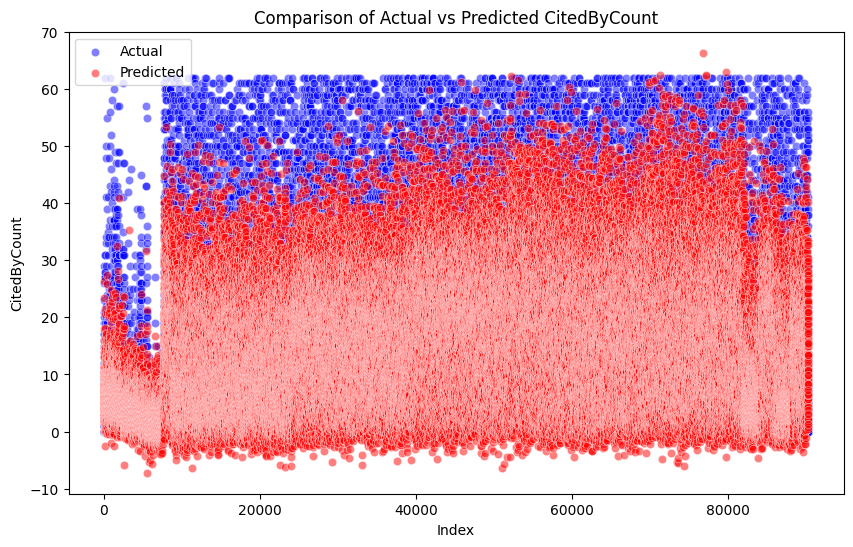

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor

model_path = 'AutogluonModels/ag-20241206_093135'
predictor = TabularPredictor.load(model_path)
best_model_name = 'WeightedEnsemble_L2'

Q1_new = new_data_df['CitedByCount'].quantile(0.25)
Q3_new = new_data_df['CitedByCount'].quantile(0.75)
IQR_new = Q3_new - Q1_new
lower_bound_new = Q1_new - 1.5 * IQR_new
upper_bound_new = Q3_new + 1.5 * IQR_new
filtered_new_data_df = new_data_df[(new_data_df['CitedByCount'] >= lower_bound_new) & (new_data_df['CitedByCount'] <= upper_bound_new)]

# Filter out rows with empty 'AuthorKeywords'
filtered_new_data_df = filtered_new_data_df[filtered_new_data_df['AuthorKeywords'].str.strip() != ""]

# Predict on the new data using the best model
new_predictions = predictor.predict(filtered_new_data_df, model=best_model_name)

# Assuming the labels are in a column named 'CitedByCount'
new_labels = filtered_new_data_df['CitedByCount']

# Calculate MSE for the new data
new_mse = mean_squared_error(new_labels, new_predictions)

print(f"Mean Squared Error (MSE) for {best_model_name} on new data: {new_mse:.4f}")

# Display the predicted values along with the actual values
predicted_vs_actual = pd.DataFrame({
    'Actual': new_labels,
    'Predicted': new_predictions
})

# predicted_vs_actual.to_csv('predicted_vs_actual.csv', index=False)

# Display the DataFrame
predicted_vs_actual

# Plot the comparison
plt.figure(figsize=(10, 6))
# Plot actual values
sns.scatterplot(x=predicted_vs_actual.index, y='Actual', data=predicted_vs_actual, color='blue', label='Actual', alpha=0.5)

# Plot predicted values
sns.scatterplot(x=predicted_vs_actual.index, y='Predicted', data=predicted_vs_actual, color='red', label='Predicted', alpha=0.5)

plt.xlabel('Index')
plt.ylabel('CitedByCount')
plt.title('Comparison of Actual vs Predicted CitedByCount')
plt.legend()
plt.show()

IF YOU WANT TO SAVE IT

In [19]:
predicted_vs_actual.to_csv('predicted_vs_actual2.csv', index=False)